In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
from os import system
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
import json
import os

/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/pytorch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.get_device_name(device))

SOS_token = 0
EOS_token = 1

hidden_size = 512
vocab_size = 28
teacher_forcing_ratio = 0.4
LR = 0.05

reference = 'variable'
output = 'varable'

#compute BLEU-4 score
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

cuda:2 NVIDIA GeForce RTX 2080 Ti


In [10]:
train_data_path = "./train.json"
test_data_path = "./test.json"
new_test_data_path = "./new_test.json"

In [3]:
def save_weight(net, save_path, name: str):
    torch.save(net.state_dict(), os.path.join(save_path, f"checkpoint_{name}.weight"))

def load_weight(net, save_path, name: str):
    net.load_state_dict(torch.load(os.path.join(save_path, f"checkpoint_{name}.weight")))

In [4]:
class Dataloader():
    def __init__(self, path):
        self.data_path = path
        self.data = []
        self.vocab_table_idx2word = {0: "SOS", 1: "EOS"}
        self.vocab_table_word2idx = {}

        # read json
        with open(self.data_path) as f:
            data_json = json.load(f)
        # combine inputs and labels
        for ele in data_json:
            inputs = ele["input"]
            label = ele["target"]
            for ins in inputs:
                self.data.append([ins, label])

        # make vocab table
        for idx, ele in enumerate("abcdefghijklmnopqrstuvwxyz"):
            self.vocab_table_idx2word[idx+2] = ele
        self.vocab_table_word2idx = {v: k for k, v in self.vocab_table_idx2word.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        idx = idx % len(self.data)

        input = self.data[idx][0]
        label = self.data[idx][1]

        # char to idx
        idx_input = np.array([0] + [self.vocab_table_word2idx[ele] for ele in input] + [1])
        idx_label = np.array([0] + [self.vocab_table_word2idx[ele] for ele in label] + [1])
        
        return torch.from_numpy(idx_input.reshape(-1, 1)).to(device), torch.from_numpy(idx_label.reshape(-1, 1)).to(device)


In [8]:
dl = Dataloader(train_data_path)
x, y = dl[0]
print(x)
print(x.shape)

tensor([[ 0],
        [ 2],
        [14],
        [ 6],
        [19],
        [ 2],
        [ 4],
        [ 2],
        [ 1]], device='cuda:2')
torch.Size([9, 1])


In [5]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layer=1, bi=False, dropout=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.latyer = layer
        self.bi = bi

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.latyer, bidirectional=self.bi, dropout=dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input)  # remove view() when input all tensor
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.latyer * (2 if self.bi else 1), 1, self.hidden_size, device=device), torch.zeros(self.latyer * (2 if self.bi else 1), 1, self.hidden_size, device=device))

#Decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, layer=1, bi=False, dropout=0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.layer = layer
        self.bi = bi

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=self.layer, bidirectional=self.bi, dropout=dropout)
        self.out = nn.Linear(hidden_size * (2 if self.bi else 1), output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output[0])    
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.layer * (2 if self.bi else 1), 1, self.hidden_size, device=device), torch.zeros(self.layer * (2 if self.bi else 1), 1, self.hidden_size, device=device))

In [7]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=20):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    #----------sequence to sequence part for encoder----------#
    
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
	
    # ####
    #----------sequence to sequence part for decoder----------#
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [8]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # your own dataloader
    training_pairs = Dataloader(train_data_path)

    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))


#trainIters(encoder1, decoder1, 200000, print_every=5000, learning_rate=LR)

In [ ]:
try:
    encoder1 = EncoderRNN(vocab_size, hidden_size, layer=3, bi=True, dropout=0.2).to(device)
    decoder1 = DecoderRNN(hidden_size, vocab_size, layer=3, bi=True, dropout=0.2).to(device)
    trainIters(encoder1, decoder1, 646250, print_every=12925, learning_rate=LR)
except KeyboardInterrupt:
    save_weight(encoder1, "./checkpoint", "encoderjpV2_interrupt")
    save_weight(decoder1, "./checkpoint", "decoderjpV2_interrupt")
    print("save interrupt")
save_weight(encoder1, "./checkpoint", "encoderjpV2")
save_weight(decoder1, "./checkpoint", "decoderjpV2")
print("save final")

7m 49s (- 383m 15s) (12925 2%) 1.1622
15m 42s (- 377m 10s) (25850 4%) 0.9058
23m 30s (- 368m 24s) (38775 6%) 0.7933
31m 22s (- 360m 46s) (51700 8%) 0.7071
39m 10s (- 352m 36s) (64625 10%) 0.6386
47m 0s (- 344m 41s) (77550 12%) 0.5792
54m 51s (- 336m 59s) (90475 14%) 0.5410
62m 37s (- 328m 45s) (103400 16%) 0.4939
70m 28s (- 321m 4s) (116325 18%) 0.4699
77m 57s (- 311m 48s) (129250 20%) 0.4427
85m 50s (- 304m 21s) (142175 22%) 0.4151
93m 40s (- 296m 38s) (155100 24%) 0.4033
101m 36s (- 289m 10s) (168025 26%) 0.3908
109m 41s (- 282m 2s) (180950 28%) 0.3823
117m 42s (- 274m 38s) (193875 30%) 0.3601
125m 31s (- 266m 44s) (206800 32%) 0.3501
133m 29s (- 259m 7s) (219725 34%) 0.3324
141m 23s (- 251m 22s) (232650 36%) 0.3395
149m 22s (- 243m 43s) (245575 38%) 0.3310
157m 10s (- 235m 45s) (258500 40%) 0.3350
165m 6s (- 228m 0s) (271425 42%) 0.3100
173m 7s (- 220m 20s) (284350 44%) 0.3079
180m 27s (- 211m 50s) (297275 46%) 0.3161
188m 23s (- 204m 5s) (310200 48%) 0.3054
196m 26s (- 196m 26s) (3

[1.1622, 0.9058, 0.7933, 0.7071, 0.6386, 0.5792, 0.541, 0.4939, 0.4699, 0.4427, 0.4151, 0.4033, 0.3908, 0.3823, 0.3601, 0.3501, 0.3324, 0.3395, 0.331, 0.335, 0.31, 0.3079, 0.3161, 0.3054, 0.2929, 0.2995, 0.2985, 0.2885, 0.2776, 0.2906, 0.2823, 0.2729, 0.2816, 0.2688, 0.2773, 0.2794]


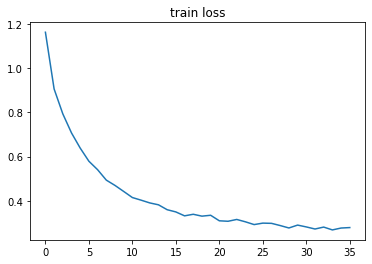

In [9]:
fake = """7m 49s (- 383m 15s) (12925 2%) 1.1622
15m 42s (- 377m 10s) (25850 4%) 0.9058
23m 30s (- 368m 24s) (38775 6%) 0.7933
31m 22s (- 360m 46s) (51700 8%) 0.7071
39m 10s (- 352m 36s) (64625 10%) 0.6386
47m 0s (- 344m 41s) (77550 12%) 0.5792
54m 51s (- 336m 59s) (90475 14%) 0.5410
62m 37s (- 328m 45s) (103400 16%) 0.4939
70m 28s (- 321m 4s) (116325 18%) 0.4699
77m 57s (- 311m 48s) (129250 20%) 0.4427
85m 50s (- 304m 21s) (142175 22%) 0.4151
93m 40s (- 296m 38s) (155100 24%) 0.4033
101m 36s (- 289m 10s) (168025 26%) 0.3908
109m 41s (- 282m 2s) (180950 28%) 0.3823
117m 42s (- 274m 38s) (193875 30%) 0.3601
125m 31s (- 266m 44s) (206800 32%) 0.3501
133m 29s (- 259m 7s) (219725 34%) 0.3324
141m 23s (- 251m 22s) (232650 36%) 0.3395
149m 22s (- 243m 43s) (245575 38%) 0.3310
157m 10s (- 235m 45s) (258500 40%) 0.3350
165m 6s (- 228m 0s) (271425 42%) 0.3100
173m 7s (- 220m 20s) (284350 44%) 0.3079
180m 27s (- 211m 50s) (297275 46%) 0.3161
188m 23s (- 204m 5s) (310200 48%) 0.3054
196m 26s (- 196m 26s) (323125 50%) 0.2929
204m 20s (- 188m 37s) (336050 52%) 0.2995
212m 26s (- 180m 57s) (348975 54%) 0.2985
220m 26s (- 173m 12s) (361900 56%) 0.2885
228m 9s (- 165m 12s) (374825 57%) 0.2776
236m 14s (- 157m 29s) (387750 60%) 0.2906
244m 12s (- 149m 40s) (400675 62%) 0.2823
252m 13s (- 141m 52s) (413600 64%) 0.2729
260m 11s (- 134m 2s) (426525 66%) 0.2816
266m 23s (- 125m 21s) (439450 68%) 0.2688
273m 56s (- 117m 24s) (452375 70%) 0.2773
280m 45s (- 109m 10s) (465300 72%) 0.2794"""
a = [float(x.split()[-1]) for x in [j for j in fake.split("\n")]]
import matplotlib.pyplot as plt
print(a)
plt.plot(a)
plt.title("train loss")
plt.show()

In [6]:
encoder1 = EncoderRNN(vocab_size, hidden_size, layer=3, bi=True).to(device)
decoder1 = DecoderRNN(hidden_size, vocab_size, layer=3, bi=True).to(device)
load_weight(encoder1, "./checkpoint", "encoderjpV2")
load_weight(decoder1, "./checkpoint", "decoderjpV2")

In [8]:
def test(encoder, decoder, path, max_length=20, show=True):
    # your own dataloader
    testing_pairs = Dataloader(path)
    print(f"testing num pair: {len(testing_pairs)}")
    bleu4 = 0
    with torch.no_grad():
        for iter in range(1, len(testing_pairs)+1):
            testing_pair = testing_pairs[iter - 1]
            input_tensor = testing_pair[0]
            target_tensor = testing_pair[1]

            target_length = target_tensor.size(0)

            encoder_hidden = encoder.initHidden()
            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden = encoder_hidden

            output_list = []
            

            for di in range(max_length):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()
                
                if decoder_input.cpu().numpy().item() == 1:
                    break
                else:
                    output_list.append(decoder_input.cpu().numpy())

            input_list = input_tensor.detach().cpu().numpy()
            label_list = target_tensor.detach().cpu().numpy()

            input_word = ''.join([testing_pairs.vocab_table_idx2word[x.item(0)] for x in input_list[1:-1]])
            label_word = ''.join([testing_pairs.vocab_table_idx2word[x.item(0)] for x in label_list[1:-1]])
            pred_word = ''.join([testing_pairs.vocab_table_idx2word[x.item(0)] for x in output_list[1:]])

            bleu4 += compute_bleu(pred_word, label_word)

            if show:
                print("="*20)
                print(f"input:\t{input_word}")
                print(f"target:\t{label_word}")
                print(f"pred:\t{pred_word}")

        print(bleu4/len(testing_pairs))


In [11]:
test(encoder1, decoder1, train_data_path, show=False)

testing num pair: 12925
0.7856788355000721


In [12]:
test(encoder1, decoder1, test_data_path)

testing num pair: 50
input:	contenpted
target:	contented
pred:	contented
input:	begining
target:	beginning
pred:	beginning
input:	problam
target:	problem
pred:	problem
input:	dirven
target:	driven
pred:	drirven
input:	ecstacy
target:	ecstasy
pred:	ecstasy
input:	juce
target:	juice
pred:	juece
input:	localy
target:	locally
pred:	locally
input:	compair
target:	compare
pred:	compare
input:	pronounciation
target:	pronunciation
pred:	pronunciation
input:	transportibility
target:	transportability
pred:	transportability
input:	miniscule
target:	minuscule
pred:	minuscule
input:	independant
target:	independent
pred:	independent
input:	aranged
target:	arranged
pred:	arrenee
input:	poartry
target:	poetry
pred:	portey
input:	leval
target:	level
pred:	level
input:	basicaly
target:	basically
pred:	basically
input:	triangulaur
target:	triangular
pred:	trianguar
input:	unexpcted
target:	unexpected
pred:	unexpected
input:	stanerdizing
target:	standardizing
pred:	standardizing
input:	varable
target:	var

In [13]:
test(encoder1, decoder1, new_test_data_path)

testing num pair: 50
input:	apreciate
target:	appreciate
pred:	appreciate
input:	appeciate
target:	appreciate
pred:	appreciate
input:	apprciate
target:	appreciate
pred:	approximate
input:	apprecate
target:	appreciate
pred:	appreciate
input:	apprecite
target:	appreciate
pred:	apprecite
input:	luve
target:	love
pred:	love
input:	culd
target:	cold
pred:	cluld
input:	heart
target:	heart
pred:	shert
input:	televiseon
target:	television
pred:	television
input:	thone
target:	phone
pred:	thro
input:	phace
target:	phase
pred:	phase
input:	poam
target:	poem
pred:	poem
input:	tomorraw
target:	tomorrow
pred:	tomorrow
input:	presishan
target:	precision
pred:	precision
input:	presishion
target:	precision
pred:	precision
input:	presisian
target:	precision
pred:	precision
input:	presistion
target:	precision
pred:	presistion
input:	perver
target:	prefer
pred:	prever
input:	predgudice
target:	prejudice
pred:	preduceee
input:	predgudis
target:	prejudice
pred:	preguids
input:	recievor
target:	receiver
pre